# UEFA Euro 2024 Penalty Visualization

This notebook visualizes penalty shots from the UEFA Euro 2024 tournament using StatsBomb event data. All data is loaded from a local CSV file (`euro2024_events.csv`).

You can use the provided functions to plot penalty shotmaps for individual players or teams.

In [26]:
from statsbombpy import sb

# Get all events from all matches
all_events = sb.competition_events(
    country="Europe",
    division="UEFA Euro",
    season="2024",
    gender="male"
)

# Save to a single CSV file
output_path = '../data/euro2024_events.csv'
all_events.to_csv(output_path, index=False)

print(f"All event data saved to {output_path}")

All event data saved to ../data/euro2024_events.csv


In [1]:
import pandas as pd
import os
%matplotlib widget

# Load event data (already exported from StatsBomb)
events = pd.read_csv('../data/euro2024_shots.csv')

# Extract shots dataframe
shots_euro = events[events['type'] == 'Shot'].copy()
penalties  = events[events['shot_type'] == 'Penalty'].copy()
euro_matches = pd.read_csv('../data/euro2024_matches.csv')

matches = euro_matches[['match_id', 'home_team', 'away_team']]
def get_opponent(row):
    if row['team'] == row['home_team']:
        return row['away_team']
    elif row['team'] == row['away_team']:
        return row['home_team']
    return None

shots_euro = shots_euro.merge(matches, on='match_id', how='left')
shots_euro['opponent_team'] = shots_euro.apply(get_opponent, axis=1)
penalties = penalties.merge(matches, on='match_id', how='left')
penalties['opponent_team'] = penalties.apply(get_opponent, axis=1)

pd.set_option('display.max_columns', None)

## Penalty Visualization Functions

The following functions allow you to plot penalty shotmaps and analyze penalties by player or team.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
from matplotlib.lines import Line2D
import mplcursors  # Added for interactive tooltips

def draw_goal(
    *,
    theme: str = "green",              
    figsize=(12, 6),
    depth_scale: float = 0.2,         # meters -> plot units (vertical scaling)
    width_scale: float = 3.0,         # how many goal widths to show horizontally
    draw_net: bool = True,
    net_spacing: float = 0.35,
    net_alpha: float = 0.18,
    show_penalty_spot: bool = True,
    show_six_yard_box: bool = True,
    show_penalty_area: bool = True,
    penalty_spot_distance: float = 11.0, 
    six_yard_depth: float = 5.5,          
    penalty_area_depth: float = 16.5,     
    title: str | None = "Penalty Area View",
):
    """
    Zoomed penalty view where the goal is the main feature.
    - Vertical axis compressed by depth_scale.
    - Horizontal axis is scaled relative to the goal's width.
    """
    # ---------- Theme ----------
    t = theme.lower()
    if t == "white":
        PITCH_BG, LINE, NET, TEXT = "#f7f7f7", "#333333", "#aaaaaa", "#111111"
    elif t == "black":
        PITCH_BG, LINE, NET, TEXT = "#000000", "#e6e6e6", "#e6e6e6", "#e6e6e6"
    else:  # green
        PITCH_BG, LINE, NET, TEXT = "#2d5e2e", "white", "white", "black"

    # ---------- Geometry ----------
    GOAL_Y_MIN, GOAL_Y_MAX = 36.0, 44.0
    GOAL_CENTER_Y, GOAL_Z_MAX = 40.0, 2.67
    GOAL_WIDTH = GOAL_Y_MAX - GOAL_Y_MIN  # 8 SB units (~7.32m)

    # Boxes in SB units
    SIX_LEFT, SIX_RIGHT = 30.0, 50.0
    PEN_LEFT, PEN_RIGHT = 18.0, 62.0

    # Vertical compression
    def z_m(d_m): 
        return -d_m * depth_scale
    z_six = z_m(six_yard_depth)
    z_pen = z_m(penalty_area_depth)
    z_spot = z_m(penalty_spot_distance)

    # Horizontal view scaled to goal width
    span = GOAL_WIDTH * width_scale / 2
    x_left = GOAL_CENTER_Y - span
    x_right = GOAL_CENTER_Y + span

    # ---------- Figure ----------
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(PITCH_BG)
    ax.set_facecolor(PITCH_BG)
    lw = 1.6

    # Goal line
    ax.plot([PEN_LEFT, PEN_RIGHT], [0, 0], color=LINE, lw=lw, zorder=2)

    # Goal frame
    goal_rect = Rectangle((GOAL_Y_MIN, 0), GOAL_WIDTH, GOAL_Z_MAX,
                          fill=False, linewidth=3, edgecolor=LINE, zorder=4)
    ax.add_patch(goal_rect)

    # Net
    if draw_net:
        for y in np.arange(GOAL_Y_MIN + net_spacing, GOAL_Y_MAX, net_spacing):
            ax.plot([y, y], [0, GOAL_Z_MAX], lw=0.8, color=NET, alpha=net_alpha, zorder=1)
        for z in np.arange(net_spacing, GOAL_Z_MAX, net_spacing):
            ax.plot([GOAL_Y_MIN, GOAL_Y_MAX], [z, z], lw=0.8, color=NET, alpha=net_alpha, zorder=1)

    # 6-yard box (only draw if within cropped view)
    if show_six_yard_box:
        ax.plot([SIX_LEFT, SIX_LEFT],   [0, z_six], color=LINE, lw=lw, zorder=3)
        ax.plot([SIX_RIGHT, SIX_RIGHT], [0, z_six], color=LINE, lw=lw, zorder=3)
        ax.plot([SIX_LEFT, SIX_RIGHT],  [z_six, z_six], color=LINE, lw=lw, zorder=3)

    # 18-yard box
    if show_penalty_area:
        ax.plot([PEN_LEFT, PEN_LEFT],   [0, z_pen], color=LINE, lw=lw, zorder=2)
        ax.plot([PEN_RIGHT, PEN_RIGHT], [0, z_pen], color=LINE, lw=lw, zorder=2)
        ax.plot([PEN_LEFT, PEN_RIGHT],  [z_pen, z_pen], color=LINE, lw=lw, zorder=2)

    # Penalty spot
    if show_penalty_spot:
        ax.plot([GOAL_CENTER_Y - 0.14, GOAL_CENTER_Y + 0.14],
                [z_spot, z_spot], color=LINE, lw=3, solid_capstyle='round', zorder=4)

    # Cosmetics
    ax.set_xlim(x_left, x_right)
    ax.set_ylim(z_pen - 0.5, GOAL_Z_MAX + 0.6)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    if title:
        ax.set_title(title, color=TEXT, pad=12, fontsize=16, fontweight='bold')

    plt.tight_layout()
    return fig, ax

def plot_shot_locations(
    shots_df: pd.DataFrame,
    *,
    outcome_col: str = 'shot_outcome',
    jitter: float = 0.08,
    palette: str = 'neutral',  # 'vibrant', 'neutral', 'classic'
    savepath: str = None,
    shot_type: str = None,     # NEW: filter by shot_type
    **kwargs
):
    """
    Draws the goal using draw_goal and plots shot locations on it,
    differentiating between regular play and shootouts, with styled KPIs.
    
    Args:
        palette (str): The color scheme for goals/misses.
            - 'vibrant': Blue for goals, orange for misses.
            - 'neutral': Dark gray for goals, light gray for misses.
            - 'classic': Green for goals, red for misses.
        shot_type (str): If provided, filter shots by this type.
    """
    # 1. Filter by shot_type if provided
    df = shots_df.copy()
    if shot_type:
        df = df[df['shot_type'] == shot_type].copy()
    if df.empty:
        print(f"No shot data to plot for shot_type: {shot_type}")
        plt.show()
        return

    # 2. Draw the base goal visualization
    fig, ax = draw_goal(**kwargs)

    # Robustly extract end_x, end_y, end_z from shot_end_location
    def extract_xyz(val):
        # Handles both list-like and stringified lists
        if isinstance(val, (list, tuple)) and len(val) == 3:
            return val
        if isinstance(val, str):
            try:
                arr = eval(val)
                if isinstance(arr, (list, tuple)) and len(arr) == 3:
                    return arr
            except Exception:
                pass
        return [np.nan, np.nan, np.nan]

    xyz = df['shot_end_location'].apply(extract_xyz).tolist()
    df[['end_x', 'end_y', 'end_z']] = pd.DataFrame(xyz, index=df.index)
    df['is_goal'] = df[outcome_col].astype(str).eq('Goal')

    # 3. Define colors, fonts, and plot points based on palette
    if palette == 'vibrant':
        GOAL_COLOR = "#1f77b4"  # Blue
        MISS_COLOR = "#ff7f0e"  # Orange
    elif palette == 'classic':
        GOAL_COLOR = "#2ca02c"  # Green
        MISS_COLOR = "#d62728"  # Red
    else:  # 'neutral' is the default
        GOAL_COLOR = "#222222"  # Dark Gray
        MISS_COLOR = "#bbbbbb"  # Light Gray
    
    theme = kwargs.get("theme", "green")
    edge_color = "#333333" if theme == "white" else "black"
    text_color = "#111111" if theme == "white" else "white"
    legend_face = "#ffffff" if theme == "white" else "#dce7d1"
    if theme == "green":
        text_color = "black"

    # --- Use a unique font for all text elements ---
    font_props = {'family': 'DejaVu Sans Mono', 'weight': 'bold'}
    ax.set_title(kwargs.get("title", ""), color=text_color, pad=15, fontsize=18, **font_props)

    # Prepare data for single scatter call
    ys = []
    zs = []
    colors = []
    play_types = []
    for _, row in df.iterrows():
        ys.append(row['end_y'] + np.random.uniform(-jitter, jitter))
        zs.append(row['end_z'] + np.random.uniform(-jitter, jitter))
        colors.append(GOAL_COLOR if row['is_goal'] else MISS_COLOR)
        play_types.append('Shootout' if row.get('period', None) == 5 else 'Regular Play')
    # Plot all points as circles
    sc = ax.scatter(
        ys, zs, s=120, alpha=0.9, facecolors=colors,
        edgecolors=edge_color, linewidth=1.2, zorder=5, marker='o'
    )
    # Set popup text color based on theme
    popup_color = {
        "green": "black",
        "white": "#222222",
        "black": "white"
    }.get(theme, "black")
    # Add mplcursors tooltips
    cursor = mplcursors.cursor(sc, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        i = sel.index
        info = df.iloc[i]
        play_type = play_types[i]
        # Tooltip includes player, team, opponent, play_pattern, body_part, shot_type
        sel.annotation.set_text(
            f"{info['player']}\n{info['team']} vs {info['opponent_team']}\n{play_type}\nPattern: {info.get('play_pattern', '')}\nBody: {info.get('shot_body_part', '')}\nType: {info.get('shot_type', '')}"
        )
        sel.annotation.get_bbox_patch().set(fc="#f7f7f7", ec=popup_color)
        sel.annotation.set_color(popup_color)
    # 4. Add a custom legend with the unique font
    legend_handles = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=11,
               markerfacecolor=GOAL_COLOR, markeredgecolor=edge_color, label='Goal'),
        Line2D([0], [0], marker='o', linestyle='None', markersize=11,
               markerfacecolor=MISS_COLOR, markeredgecolor=edge_color, label='No Goal'),
    ]
    leg = ax.legend(handles=legend_handles, loc='upper left', frameon=True, fontsize=10)
    leg.get_frame().set_facecolor(legend_face)
    leg.get_frame().set_edgecolor(edge_color)
    for txt in leg.get_texts():
        txt.set_fontproperties(font_props)
        txt.set_color(text_color)

    # 5. Calculate and display structured KPIs on the right
    total = len(df)
    goals = int(df['is_goal'].sum())
    not_goals = total - goals
    goal_rate = 100 * goals / total if total else 0
    
    miss_types = df.loc[~df['is_goal'], outcome_col].value_counts().sort_index()
    
    body_part_counts = df['shot_body_part'].value_counts()
    right_foot = int(body_part_counts.get('Right Foot', 0))
    left_foot  = int(body_part_counts.get('Left Foot', 0))
    
    shootout_count = int((df['period'] == 5).sum())
    regular_count = total - shootout_count

    # Get plot coordinates for positioning
    x_right = ax.get_xlim()[1]
    y_top = ax.get_ylim()[1]
    
    # Position the structured KPI block with left alignment
    kx = 44.6  # Start text to the right of the goal
    ky = y_top + 0.1
    
    # --- Main Summary ---
    ax.text(kx, ky, f"{total} Total Penalties", ha='left', va='top', fontsize=14, color=text_color, **font_props)
    ky -= 0.4
    ax.text(kx, ky, f"{goals} Scored ({goal_rate:.1f}%)", ha='left', va='top', fontsize=13, color=GOAL_COLOR, **font_props)
    ky -= 0.4
    ax.text(kx, ky, f"{not_goals} Missed/Saved", ha='left', va='top', fontsize=13, color=MISS_COLOR, **font_props)
    
    # --- Miss Breakdown ---
    ky -= 0.35
    for miss_type, count in miss_types.items():
        ax.text(kx + 0.5, ky, f"• {count} {miss_type}", color=MISS_COLOR, ha='left', va='top', fontsize=12, **font_props)
        ky -= 0.3
    
    # --- Details Section ---
    ky -= 0.3
    ax.text(kx, ky, "Details", ha='left', va='top', fontsize=13, color=text_color, **font_props)
    ky -= 0.30

    # Align the '|' separator by padding the first part of the string
    part1_reg = f"Regular Play: {regular_count}"
    part1_foot = f"Right Foot: {right_foot}"
    max_len = max(len(part1_reg), len(part1_foot))

    line1 = f"{part1_reg:<{max_len}} | Shootout: {shootout_count}"
    line2 = f"{part1_foot:<{max_len}} | Left Foot: {left_foot}"

    ax.text(kx, ky, line1, ha='left', va='top', fontsize=12, color=text_color, **font_props)
    ky -= 0.3
    ax.text(kx, ky, line2, ha='left', va='top', fontsize=12, color=text_color, **font_props)

    plt.tight_layout()
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()

def plot_penalties_by_filter(
    shots_df: pd.DataFrame,
    *,
    player_name: str | None = None,
    team_name: str | None = None,
    savepath: str = None,
    **kwargs
):
    """
    Filters penalties for a specific player or team and plots them
    using the main plot_shot_locations function.
    """
    # Always filter from the full events dataframe, not just shots
    penalties_df = shots_df.copy()  # shots_df should be the full penalties dataframe

    if player_name:
        filtered_df = penalties_df[penalties_df['player'] == player_name].copy()
        title = f"Penalty Analysis for {player_name}"
    elif team_name:
        filtered_df = penalties_df[penalties_df['team'] == team_name].copy()
        title = f"Penalty Analysis for {team_name}"
    else:
        print("Please provide a player_name or team_name to filter by.")
        return

    if filtered_df.empty:
        filter_type = "player" if player_name else "team"
        filter_value = player_name or team_name
        print(f"No penalty data found for {filter_type}: {filter_value}")
        return

    kwargs['title'] = title
    kwargs['savepath'] = savepath
    plot_shot_locations(filtered_df, **kwargs)

def draw_full_pitch(
    *,
    theme: str = "green",
    figsize=(12, 6),
    title: str | None = None,
):
    """
    Draws a full soccer pitch based on StatsBomb coordinates (120x80).
    - Uses matplotlib patches to draw all pitch markings.
    - The style is consistent with the draw_goal function.
    """
    # ---------- Theme ----------
    t = theme.lower()
    if t == "white":
        PITCH_BG, LINE, TEXT = "#f7f7f7", "#333333", "#111111"
    elif t == "black":
        PITCH_BG, LINE, TEXT = "#000000", "#e6e6e6", "#e6e6e6"
    else:  # green
        PITCH_BG, LINE, TEXT = "#2d5e2e", "white", "black"

    # ---------- Figure Setup ----------
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(PITCH_BG)
    ax.set_facecolor(PITCH_BG)
    lw = 2.0

    # ---------- Pitch Markings (StatsBomb coordinates) ----------
    # Outer lines
    ax.add_patch(Rectangle((0, 0), 120, 80, fill=False, edgecolor=LINE, lw=lw))

    # Halfway line
    ax.plot([60, 60], [0, 80], color=LINE, lw=lw)

    # Center circle and spot
    ax.add_patch(plt.Circle((60, 40), radius=10, fill=False, edgecolor=LINE, lw=lw))
    ax.add_patch(plt.Circle((60, 40), radius=0.5, fill=True, color=LINE))

    # Penalty areas
    ax.add_patch(Rectangle((0, 18), 18, 44, fill=False, edgecolor=LINE, lw=lw))
    ax.add_patch(Rectangle((102, 18), 18, 44, fill=False, edgecolor=LINE, lw=lw))

    # Goal areas (6-yard box)
    ax.add_patch(Rectangle((0, 30), 6, 20, fill=False, edgecolor=LINE, lw=lw))
    ax.add_patch(Rectangle((114, 30), 6, 20, fill=False, edgecolor=LINE, lw=lw))

    # Penalty spots
    ax.add_patch(plt.Circle((12, 40), radius=0.5, fill=True, color=LINE))
    ax.add_patch(plt.Circle((108, 40), radius=0.5, fill=True, color=LINE))
    
    # Penalty arcs
    arc_left = Arc((12, 40), height=20, width=20, angle=0, theta1=310, theta2=50, color=LINE, lw=lw)
    arc_right = Arc((108, 40), height=20, width=20, angle=0, theta1=130, theta2=230, color=LINE, lw=lw)
    ax.add_patch(arc_left)
    ax.add_patch(arc_right)

    # Corner arcs
    ax.add_patch(Arc((0, 0), height=2, width=2, angle=0, theta1=0, theta2=90, color=LINE, lw=lw))
    ax.add_patch(Arc((120, 0), height=2, width=2, angle=0, theta1=90, theta2=180, color=LINE, lw=lw))
    ax.add_patch(Arc((120, 80), height=2, width=2, angle=0, theta1=180, theta2=270, color=LINE, lw=lw))
    ax.add_patch(Arc((0, 80), height=2, width=2, angle=0, theta1=270, theta2=360, color=LINE, lw=lw))
    
    # Goals
    ax.plot([0, 0], [36, 44], color=LINE, lw=lw+1)
    ax.plot([120, 120], [36, 44], color=LINE, lw=lw+1)

    # ---------- Cosmetics ----------
    ax.set_xlim(-2, 122)
    ax.set_ylim(-2, 82)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    if title:
        ax.set_title(title, color=TEXT, pad=12, fontsize=16, fontweight='bold')

    plt.tight_layout()
    return fig, ax

## Example Usage

Plot penalties for a specific player or team:

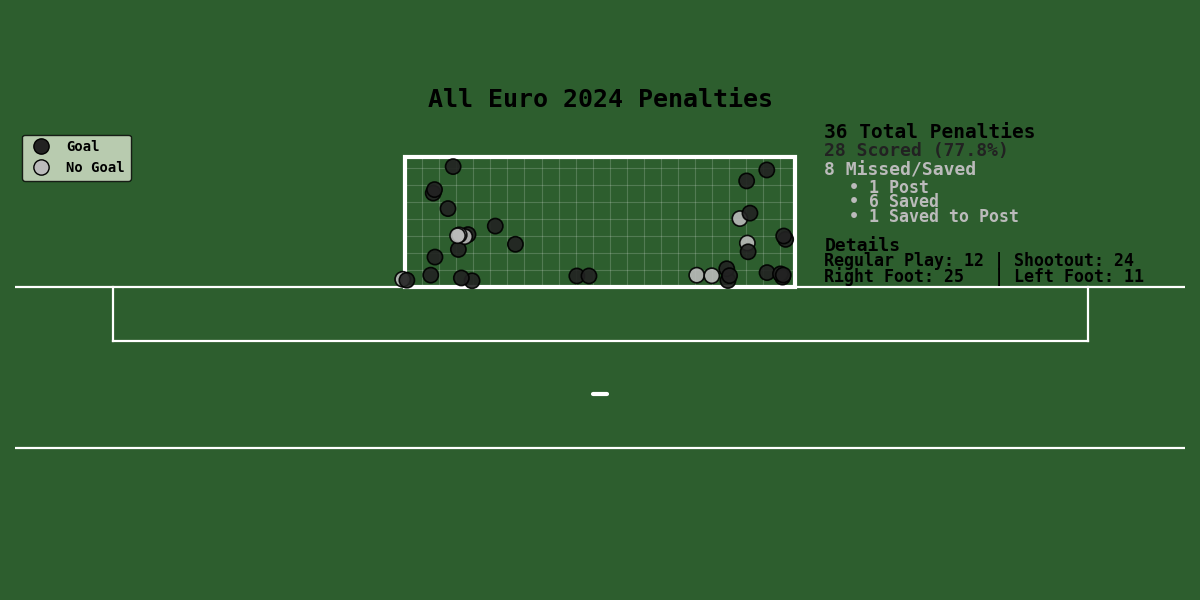

In [3]:
# Plot all penalties in the tournament and save
plot_shot_locations(
    penalties,
    theme="green",
    palette="neutral",
    title="All Euro 2024 Penalties",
    # savepath="plots/all_penalties.png"
)

# # Plot for a specific team and save
# plot_penalties_by_filter(
#     penalties,
#     team_name="Portugal",
#     theme="black",
#     palette="classic",
#     savepath="plots/portugal.png"
# )

# # Plot for a specific player and save
# plot_penalties_by_filter(
#     penalties,
#     player_name="Cristiano Ronaldo dos Santos Aveiro",
#     theme="white",
#     palette="vibrant",
#     savepath="plots/ronaldo.png"
#)

In [4]:
free_kicks = shots_euro[shots_euro['shot_type'] == 'Free Kick']

open_play = shots_euro[shots_euro['shot_type'] == 'Open Play']

corner_shots = shots_euro[shots_euro['shot_type'] == 'Corner']

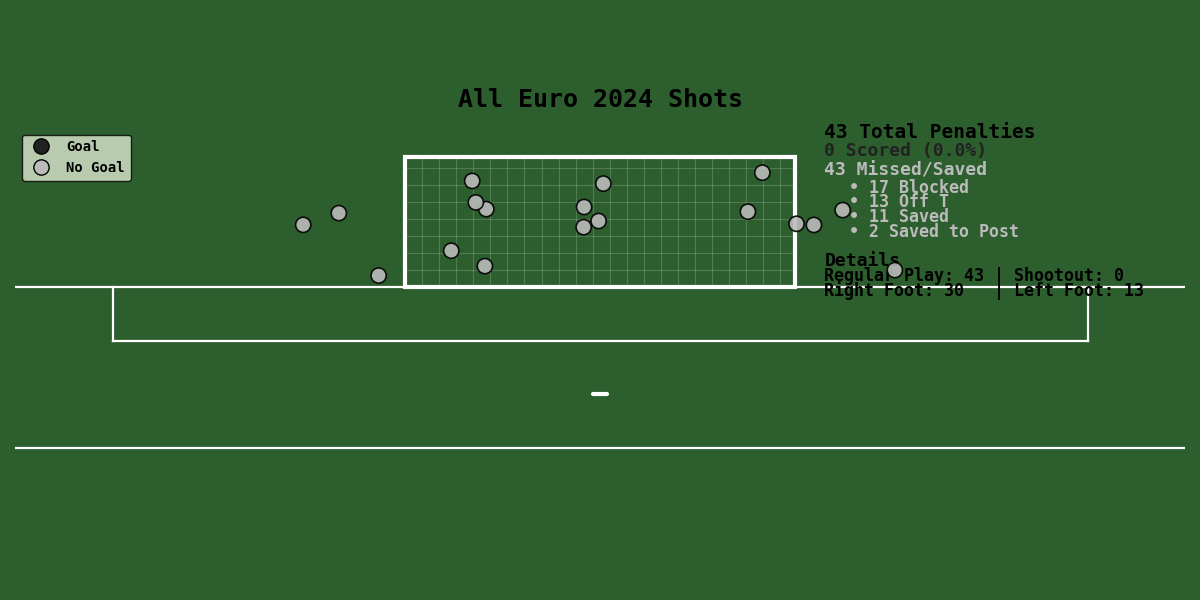

In [5]:
# Plot all shots in the tournament (not just penalties) and save
plot_shot_locations(
    free_kicks,
    theme="green",
    palette="neutral",
    title="All Euro 2024 Shots",
    #savepath="plots/all_shots.png"
)

# shot_statsbomb_xg

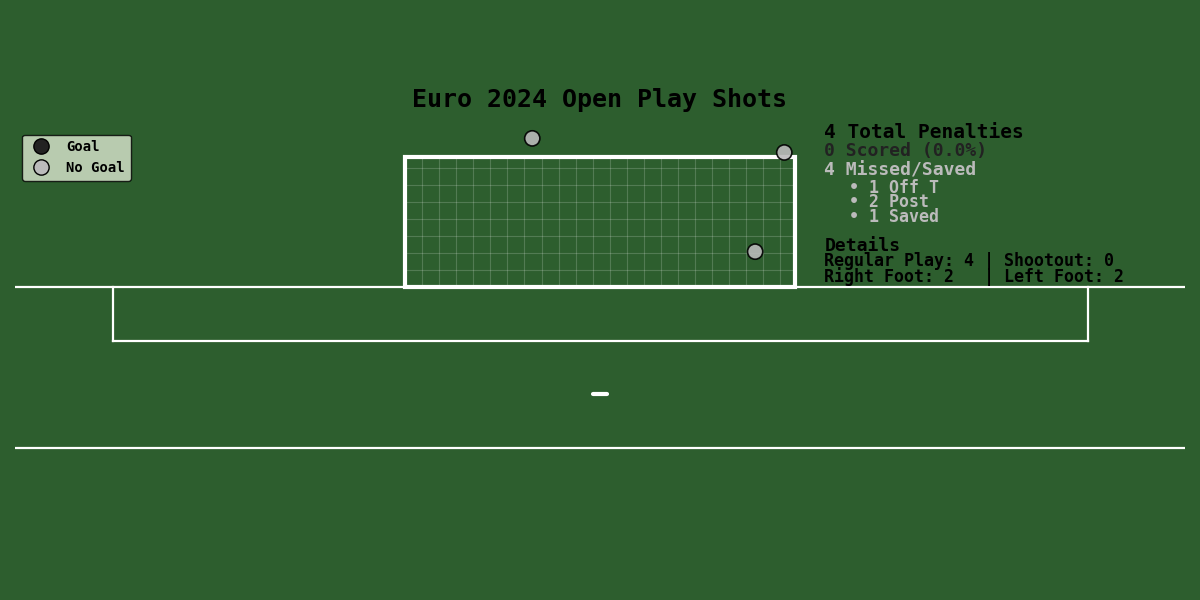

In [6]:
# Example: Plot only Free Kick shots with enhanced tooltips
plot_shot_locations(
    shots_euro,
    shot_type="Corner",
    theme="green",
    palette="neutral",
    title="Euro 2024 Open Play Shots",
    #savepath="plots/open_play_shots.png"
)

In [7]:
passes_euro = pd.read_csv('../data/euro2024_passes.csv')

C:\Users\pavle\AppData\Local\Temp\ipykernel_13592\2400209233.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  passes_euro = pd.read_csv('../data/euro2024_passes.csv')


In [8]:
print(passes_euro.shape)
passes_euro.head(2)

(53890, 48)


,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,match_id,pass_recipient,pass_length,pass_angle,pass_height,pass_end_location,pass_body_part,pass_type,possession_team_id,team_id,player_id,pass_recipient_id,under_pressure,pass_outcome,off_camera,pass_through_ball,pass_technique,pass_aerial_won,pass_cross,pass_assisted_shot_id,pass_shot_assist,pass_switch,counterpress,pass_deflected,pass_outswinging,pass_cut_back,pass_goal_assist,pass_inswinging,pass_no_touch,pass_straight,out,pass_miscommunication
0,25dfc952-7a85-464f-b884-982064d46cc9,5,1,00:00:00.355,0,0,Pass,2,England,From Kick Off,England,Kobbie Mainoo,Right Defensive Midfield,"[60.0, 40.0]",2.455156,['85328a9c-e246-4273-b566-353b64d902a1'],3942819,Jordan Pickford,34.738163,-2.982596,Ground Pass,"[25.7, 34.5]",Right Foot,Kick Off,768,768,99174,3468.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8a920161-a913-4ce5-be61-9d6ae7466469,9,1,00:00:05.294,0,5,Pass,2,England,From Kick Off,England,Jordan Pickford,Goalkeeper,"[30.4, 24.1]",3.438864,"['37b46889-6085-4985-a50f-7fc2b14fc20e', 'c6e3...",3942819,NaN,65.695740,0.462286,High Pass,"[89.2, 53.4]",Left Foot,NaN,768,768,3468,NaN,True,Incomplete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# for column in passes_euro.columns:
#     #print(f"{column}: {passes_euro[column].nunique()} unique values")
#     # for all columns with less than 10 unique values, print the value counts
#     if passes_euro[column].nunique() < 10:
#         print(passes_euro[column].value_counts())
#         print('------------')

In [10]:
def plot_interactive_pass_network(match_id, team_side, theme="green"):
    """
    Generates and plots an interactive pass network for a given match and team side ('home' or 'away').
    Includes a slider to filter passes by a minimum count.
    Node size is based on the player's degree centrality (involvement in passes).
    Theme can be set to 'green', 'white', or 'black'.
    """
    import ipywidgets as widgets
    from ipywidgets import interact
    from matplotlib.patches import FancyArrowPatch
    import networkx as nx
    
    def offset_edge_coords(x1, y1, x2, y2, offset):
        vec = np.array([x2 - x1, y2 - y1])
        norm_vec = vec / np.linalg.norm(vec) if np.linalg.norm(vec) > 0 else vec
        perp_vec = np.array([-norm_vec[1], norm_vec[0]]) * offset
        return x1 + perp_vec[0], y1 + perp_vec[1], x2 + perp_vec[0], y2 + perp_vec[1]

    # --- Data Fetching and Preparation ---
    match_info = euro_matches[euro_matches['match_id'] == match_id]
    if match_info.empty:
        print(f"Match with ID {match_id} not found.")
        return
    
    if team_side == 'home':
        team_name = match_info['home_team'].iloc[0]
    elif team_side == 'away':
        team_name = match_info['away_team'].iloc[0]
    else:
        print("team_side must be 'home' or 'away'.")
        return

    team_passes = passes_euro[(passes_euro['match_id'] == match_id) & (passes_euro['team'] == team_name)]
    if team_passes.empty:
        print(f"No pass data found for {team_name} in match {match_id}.")
        return
    
    starting_11 = team_passes.sort_values('minute').drop_duplicates('player').head(11)['player'].tolist()

    player_positions = {}
    for player in starting_11:
        player_passes = team_passes[team_passes['player'] == player]
        locs = player_passes['location'].apply(lambda val: eval(val) if isinstance(val, str) else val)
        xs = [loc[0] for loc in locs if loc and len(loc) > 1]
        ys = [loc[1] for loc in locs if loc and len(loc) > 1]
        if xs and ys:
            player_positions[player] = (sum(xs)/len(xs), sum(ys)/len(ys))
        else:
            player_positions[player] = (0, 0)

    pass_counts = {}
    for _, row in team_passes.iterrows():
        passer = row['player']
        recipient = row['pass_recipient'] if 'pass_recipient' in row else None
        if passer in starting_11 and recipient in starting_11:
            key = (passer, recipient)
            pass_counts[key] = pass_counts.get(key, 0) + 1

    # Read lineups from local CSV
    lineups = pd.read_csv('../data/lineups.csv')
    team_lineup = lineups[(lineups['match_id'] == match_id) & (lineups['team_name'] == team_name)]
    team_numbers = {}
    team_nicknames = {}
    for _, player in team_lineup.iterrows():
        jersey = player['jersey_number']
        jersey_str = str(jersey) if pd.notnull(jersey) else ''
        team_numbers[player['player_name']] = jersey_str
        team_nicknames[player['player_name']] = player['player_nickname'] if pd.notnull(player['player_nickname']) else player['player_name']

    player_positions_num = {str(team_numbers.get(p, p)): pos for p, pos in player_positions.items()}
    pass_counts_num = {(str(team_numbers.get(p1, p1)), str(team_numbers.get(p2, p2))): count for (p1, p2), count in pass_counts.items()}
    
    jersey_to_display_name = {}
    for name, jersey in team_numbers.items():
        if jersey:
            jersey_to_display_name[jersey] = team_nicknames.get(name, name)

    def plot_pass_network(min_passes):
        pass_counts_num_filtered = {k: v for k, v in pass_counts_num.items() if v >= min_passes}
        G = nx.DiGraph()
        for (u, v), weight in pass_counts_num_filtered.items():
            G.add_edge(u, v, weight=weight)
        degrees = dict(G.degree())
        title = f'{team_name} Pass Network'
        fig, ax = draw_full_pitch(theme=theme, figsize=(12, 6), title=title)
        nodes_data = list(player_positions_num.items())
        node_jersey_numbers = [item[0] for item in nodes_data]
        node_positions = [item[1] for item in nodes_data]
        node_sizes = [400 + degrees.get(node, 0) * 80 for node in node_jersey_numbers]
        sc = ax.scatter(
            [p[0] for p in node_positions], [p[1] for p in node_positions],
            s=node_sizes, color='white', edgecolors='black', linewidth=1.5, zorder=2
        )
        for node, p in player_positions_num.items():
            ax.text(p[0], p[1], node, fontsize=14, color='black',
                       va='center', ha='center', zorder=3, fontweight='bold')
        import mplcursors
        cursor = mplcursors.cursor(sc, hover=True)
        @cursor.connect("add")
        def on_add(sel):
            jersey_num = node_jersey_numbers[sel.index]
            display_name = jersey_to_display_name.get(jersey_num, "Unknown")
            sel.annotation.set_text(display_name)
            sel.annotation.get_bbox_patch().set(facecolor='lightgrey', alpha=0.9)
            sel.annotation.arrow_patch.set(arrowstyle="->", facecolor="black", alpha=.5)
        bidirectional_drawn = set()
        for (u, v), weight in pass_counts_num_filtered.items():
            if (u, v) in bidirectional_drawn: continue
            x1, y1 = player_positions_num.get(str(u), (0,0))
            x2, y2 = player_positions_num.get(str(v), (0,0))
            is_bidirectional = (v, u) in pass_counts_num_filtered
            if is_bidirectional:
                x1_uv, y1_uv, x2_uv, y2_uv = offset_edge_coords(x1, y1, x2, y2, offset=0.75)
                arrow1 = FancyArrowPatch((x1_uv, y1_uv), (x2_uv, y2_uv), arrowstyle='->', mutation_scale=25, lw=weight/4, color='navy', alpha=0.7, shrinkA=20, shrinkB=10)
                ax.add_patch(arrow1)
                x1_vu, y1_vu, x2_vu, y2_vu = offset_edge_coords(x2, y2, x1, y1, offset=0.75)
                weight_vu = pass_counts_num_filtered.get((v, u), 0)
                arrow2 = FancyArrowPatch((x1_vu, y1_vu), (x2_vu, y2_vu), arrowstyle='->', mutation_scale=25, lw=weight_vu/4, color='navy', alpha=0.7, shrinkA=20, shrinkB=10)
                ax.add_patch(arrow2)
                bidirectional_drawn.add((u, v)); bidirectional_drawn.add((v, u))
            else:
                arrow = FancyArrowPatch((x1, y1), (x2, y2), arrowstyle='->', mutation_scale=25, lw=weight/4, color='navy', alpha=0.5, shrinkA=20, shrinkB=10)
                ax.add_patch(arrow)
                bidirectional_drawn.add((u, v))
        plt.show()
    interact(plot_pass_network, min_passes=widgets.IntSlider(min=1, max=max(list(pass_counts_num.values()) + [30]), step=1, value=5, description='Min Passes:'))


In [11]:
#euro_matches 3930180

plot_interactive_pass_network(match_id=3942752, team_side='home', theme='green')

interactive(children=(IntSlider(value=5, description='Min Passes:', max=30, min=1), Output()), _dom_classes=('…

In [12]:
import pandas as pd
import os

# Manually define the group for each of the 24 teams
team_to_group_map = {
    'Germany': 'Group A', 'Scotland': 'Group A', 'Hungary': 'Group A', 'Switzerland': 'Group A',
    
    'Spain': 'Group B', 'Croatia': 'Group B', 'Italy': 'Group B', 'Albania': 'Group B',
    
    'Slovenia': 'Group C', 'Denmark': 'Group C', 'Serbia': 'Group C', 'England': 'Group C',
    
    'Poland': 'Group D', 'Netherlands': 'Group D', 'Austria': 'Group D', 'France': 'Group D',
    
    'Belgium': 'Group E', 'Slovakia': 'Group E', 'Romania': 'Group E', 'Ukraine': 'Group E',
    
    'Turkey': 'Group F', 'Georgia': 'Group F', 'Portugal': 'Group F', 'Czechia': 'Group F'
}

# Convert the dictionary to a DataFrame
groups_df = pd.DataFrame(list(team_to_group_map.items()), columns=['team', 'group'])
groups_df = groups_df.sort_values(by=['group', 'team']).reset_index(drop=True)

# Define the save path
save_path = '../data/euro2024_groups.csv'

# Ensure the data directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the DataFrame to a CSV file
groups_df.to_csv(save_path, index=False)

print(f"Successfully created group data and saved to {save_path}")
print("\nPreview of the data:")
print(groups_df.to_string())


Successfully created group data and saved to ../data/euro2024_groups.csv

Preview of the data:
           team    group
0       Germany  Group A
1       Hungary  Group A
2      Scotland  Group A
3   Switzerland  Group A
4       Albania  Group B
5       Croatia  Group B
6         Italy  Group B
7         Spain  Group B
8       Denmark  Group C
9       England  Group C
10       Serbia  Group C
11     Slovenia  Group C
12      Austria  Group D
13       France  Group D
14  Netherlands  Group D
15       Poland  Group D
16      Belgium  Group E
17      Romania  Group E
18     Slovakia  Group E
19      Ukraine  Group E
20      Czechia  Group F
21      Georgia  Group F
22     Portugal  Group F
23       Turkey  Group F
